## Dynamics

Dynamics | $\partial_{\tau}x_i=$ |
| :--------: | :-------: |
Biochemical | $F -B x_i - R \sum_j A_{ij} x_i x_j$ |
Epidemics | $-B x_i + R \sum_j A_{ij} (1-x_i)x_j$ |
Population | $-B x_i^{b} + R \sum_j A_{ij} x_j^a$ |
Synchronization | $\omega_i + R \sum_j A_{ij} \sin(x_j-x_i)$ |

In [1]:
%load_ext autoreload
%autoreload 2

## Importing

In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [3]:
from utils.utils import *
import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from experiments.experiments_gkan import ExperimentsGKAN
from experiments.experiments_mpnn import ExperimentsMPNN
from train_and_eval import eval_model
import sympytorch

storage = JournalStorage(JournalFileBackend("optuna_journal_storage.log"))

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [4]:
import random
import torch
import numpy as np

def set_pytorch_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    torch.use_deterministic_algorithms(True)
set_pytorch_seed(0)

In [ ]:
# config = load_config("./configs/config_pred_deriv/config_real_epid_mpnn.yml")
# config['patience'] = 450
# exp = ExperimentsMPNN(
#     config=config,
#     n_trials=3,
#     study_name="test_mult_2"
# )

In [6]:
# exp.run()

In [ ]:
# config = load_config("./configs/config_pred_deriv/config_ic1/config_population.yml")
# # # config['t_span'] = [0, 1]
# exp = ExperimentsGKAN(
#     config=config,
#     n_trials=1,
#     study_name="test_mult_11"
# )

In [55]:
# exp.run()

[I 2025-07-22 13:05:55,302] A new study created in Journal with name: model-population-gkan-test_mult_11


Trial 0: num params: 348


[I 2025-07-22 13:20:07,691] Trial 0 finished with value: 9.843736188486218e-05 and parameters: {'lr': 0.0028057582076672534, 'lamb': 1.0, 'batch_size': 16, 'use_orig_reg': True, 'lamb_g_net': 8.63200816860254e-06, 'lamb_h_net': 8.629132190071855e-06, 'grid_size_g_net': 5, 'spline_order_g_net': 3, 'range_limit_g_net': 7, 'mu_1_g_net': 0.8, 'mu_2_g_net': 0.1, 'hidden_dim_g_net': 6, 'grid_size_h_net': 18, 'spline_order_h_net': 1, 'range_limit_h_net': 2, 'mu_1_h_net': 0.2, 'mu_2_h_net': 0.4, 'hidden_dim_h_net': 4}. Best is trial 0 with value: 9.843736188486218e-05.


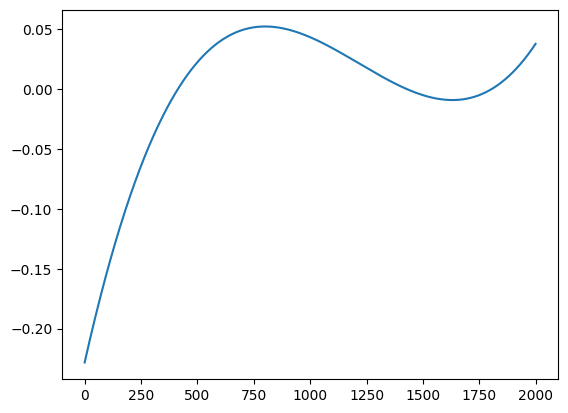

In [ ]:
# data = exp.training_set.raw_data_sampled[0].detach().cpu().numpy()
# plt.plot(data[:, 30, :])

In [9]:
# exp.training_set[0].y

In [10]:
# exp.epochs = 10
# exp.run()

In [11]:
# config_pop = load_config("./configs/config_pred_deriv/config_ic1/config_population_mpnn.yml")
# # config_pop["t_eval_steps"] = 1000
# # config_pop["t_span"] = [0, 10]

# exp = ExperimentsMPNN(
#     config=config_pop,
#     n_trials=1,
#     study_name='test_mult_3'
# )

In [12]:
# data = exp.training_set.raw_data_sampled[0].detach().cpu().numpy()
# plt.plot(data[:, 6, :])

In [13]:
# exp.training_set.raw_data_sampled.min()

In [14]:
# exp.epochs = 10
# exp.run()

## Utils

In [5]:
from models.utils.MPNN import MPNN
from models.baseline.MPNN_ODE import MPNN_ODE
from train_and_eval import eval_model
from datasets.SyntheticData import SyntheticData
from sympy import symbols, sin, summation, simplify
import networkx as nx
from torch_geometric.utils import from_networkx
from utils.utils import integrate
from torch_geometric.data import Data
from models.kan.KAN import KAN
from models.GKAN_ODE import GKAN_ODE
import torch
import numpy as np


import optuna

import warnings
warnings.filterwarnings("ignore")

from sympy import latex
from torch.utils.data import DataLoader

def get_model(g, h, message_passing=True, include_time=False, atol=1e-5, rtol=1e-5, integration_method = 'scipy_solver',
              eval=True, options = {}, all_t = False):
    conv = MPNN(
        g_net = g,
        h_net = h,
        message_passing=message_passing,
        include_time=include_time
    )

    symb = MPNN_ODE(
        conv=conv,
        model_path="./saved_models_optuna/tmp_symb",
        adjoint=True,
        integration_method=integration_method,
        atol=atol,
        rtol=rtol,
        options = options,
        all_t=all_t
    )

    if eval:
        symb = symb.eval()
    return symb


def make_callable(expr):
    free_syms = expr.free_symbols
    if not free_syms:
        # Expression is constant
        const_value = float(expr)
        return lambda x: torch.full((x.shape[0], 1), const_value, dtype=x.dtype, device=x.device)

    sym_module = sympytorch.SymPyModule(expressions=[expr])
    syms = {str(s) for s in free_syms}
    if {'x_i', 'x_j'} <= syms:
        return lambda x: sym_module(x_i=x[:, 0], x_j=x[:, 1])
    elif 'x_i' in syms:
        return lambda x: sym_module(x_i=x[:, 0])
    elif 'x_j' in syms:
        return lambda x: sym_module(x_j=x[:, 1])
    else:
        raise ValueError(f"Unexpected symbols in expression: {free_syms}")


def get_symb_test_error(g_symb, h_symb, test_set, message_passing=False, include_time=False, atol=1e-5, rtol=1e-5, scaler = None, inverse_scale=False, method='scipy_solver',
                        is_symb = True):

    if is_symb:
        if isinstance(g_symb, int):
            g_symb = sp.sympify(g_symb)

        if isinstance(h_symb, int):
            h_symb = sp.sympify(h_symb)

        g_symb = make_callable(g_symb)
        h_symb = make_callable(h_symb)

    test_losses = []

    for ts in test_set:
        symb = get_model(
            g=g_symb,
            h=h_symb,
            message_passing=message_passing,
            include_time=include_time,
            atol=atol,
            rtol=rtol,
            integration_method=method
        )

        collate_fn = lambda samples_list: samples_list
        test_loader = DataLoader(ts, batch_size=len(ts), shuffle=True, collate_fn=collate_fn)

        test_loss = eval_model(
            model=symb,
            valid_loader=test_loader,
            criterion=torch.nn.L1Loss(),
            scaler=scaler,
            inverse_scale=inverse_scale,
            pred_deriv=False
        )

        test_losses.append(test_loss)

    return test_losses



def get_test_set(dynamics, device='cuda', input_range=(0, 1), t_span = (0, 1), **integration_kwargs):
    seeds = [12345, 67890, 111213]

    graphs = [
        nx.barabasi_albert_graph(70, 3, seed=seeds[0]),
        nx.watts_strogatz_graph(50, 6, 0.3, seed=seeds[1]),
        nx.erdos_renyi_graph(100, 0.05, seed=seeds[2])
    ]

    test_set = []
    for i, graph in enumerate(graphs):
        snapshots = integrate_test_set(
            graph=graph,
            dynamics=dynamics,
            seed=seeds[i],
            device=device,
            input_range=input_range,
            t_span=t_span,
            **integration_kwargs
        )
        test_set.append(snapshots)

    return test_set



def integrate_test_set(graph, dynamics, seed=12345, device='cuda', input_range = (0, 1), t_span = (0, 1), **integration_kwargs):
    # graph = nx.barabasi_albert_graph(100, 3, seed=seed)
    edge_index = from_networkx(graph).edge_index
    edge_index = edge_index.to(torch.device(device))
    rng = np.random.default_rng(seed=seed)

    data, t = integrate(
        input_range=input_range,
        t_span = t_span,
        t_eval_steps=1000,
        dynamics=dynamics,
        device=device,
        graph=graph,
        rng = rng,
        **integration_kwargs
    )

    snapshot = Data(
        x = data[0].unsqueeze(0),
        y = data[1:],
        edge_index=edge_index,
        edge_attr=None,
        t_span = t
    )

    return [snapshot]


def build_model_from_file(model_path, message_passing, include_time, method='dopri5', adjoint=False, atol=1e-5, rtol=1e-5):
    best_params_file = f"{model_path}/best_params.json"
    best_state_path = f"{model_path}/gkan/state_dict.pth"

    with open(best_params_file, 'r') as f:
        best_hyperparams = json.load(f)

    # g_net
    g_net = KAN(
        layers_hidden=[2, best_hyperparams['hidden_dim_g_net'], 1],
        grid_size=best_hyperparams['grid_size_g_net'],
        spline_order=best_hyperparams['spline_order_g_net'],
        grid_range=[-best_hyperparams['range_limit_g_net'], best_hyperparams['range_limit_g_net']],
        mu_1=best_hyperparams['mu_1_g_net'],
        mu_2=best_hyperparams['mu_2_g_net'],
        device='cuda',
        compute_mult=True,
        store_act=True
    )

    time_dim = 1 if include_time else 0
    in_dim_h = 2 if message_passing else 1
    in_dim_h += time_dim

    # h_net
    h_net = KAN(
        layers_hidden=[in_dim_h, best_hyperparams['hidden_dim_h_net'], 1],
        grid_size=best_hyperparams['grid_size_h_net'],
        spline_order=best_hyperparams['spline_order_h_net'],
        grid_range=[-best_hyperparams['range_limit_h_net'], best_hyperparams['range_limit_h_net']],
        mu_1=best_hyperparams['mu_1_h_net'],
        mu_2=best_hyperparams['mu_2_h_net'],
        device='cuda',
        compute_mult=True,
        store_act=True
    )

    gkan = MPNN(
        h_net=h_net,
        g_net=g_net,
        message_passing=message_passing,
        include_time=include_time
    )

    model = GKAN_ODE(
        conv=gkan,
        model_path='./saved_models_optuna/tmp',
        lmbd_g=best_hyperparams['lamb_g_net'],
        lmbd_h=best_hyperparams['lamb_h_net'],
        integration_method=method,
        adjoint=adjoint,
        atol=atol,
        rtol=rtol
    )

    model = model.to(torch.device('cuda'))
    model.load_state_dict(torch.load(best_state_path, weights_only=False, map_location=torch.device('cuda')))

    return model


def valid_symb_model(
    config,
    model_path_gkan,
    device='cuda',
    atol=1e-5,
    rtol=1e-5,
    method='dopri5',
    black_box_fitting=True,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    sample_size=10000
):
    
    seed = 9999
    graph = nx.barabasi_albert_graph(100, 3, seed=seed)

    # Prepare validation/test set
    valid_set = integrate_test_set(
        graph=graph,
        dynamics=config['name'],
        seed=seed,
        device=device,
        input_range=config['input_range'],
        t_span=(0, 1),
        **config['integration_kwargs']
    )

    # Helper to compute validation loss
    def evaluate_model(g_symb, h_symb, is_symb=True):
        errs = get_symb_test_error(
            g_symb=g_symb,
            h_symb=h_symb,
            test_set=[valid_set],
            message_passing=False,
            include_time=False,
            method=method,
            atol=atol,
            rtol=rtol,
            is_symb=is_symb
        )
        return errs[0]

    # Helper to fit model for current config
    def fit_single_model(param1, param2, param3=None):
        if black_box_fitting:
            print(f"Fitting black-box model with {param1} and {param2} iterations")
            pysr_model = lambda: get_pysr_model(
                model_selection=param1, 
                n_iterations=param2,
                # parallelism="serial",
                # random_state = seed,
                # deterministic = True
            )
            _, g_symb, h_symb, _ = fit_black_box_from_kan(
                n_g_hidden_layers=n_g_hidden_layers,
                n_h_hidden_layers=n_h_hidden_layers,
                device=device,
                model_path=model_path_gkan,
                pysr_model=pysr_model,
                sample_size=sample_size,
                theta=-np.inf,
                message_passing=False,
                verbose=False
            )
        else:
            print(f"Fitting symbolic model with {param1}, theta {param2} and cutting threshold {param3}")
            _, g_symb, h_symb, _ = fit_model(
                n_g_hidden_layers=n_g_hidden_layers,
                n_h_hidden_layers=n_h_hidden_layers,
                model_path=model_path_gkan,
                theta=param2,
                message_passing=False,
                include_time=False,
                sample_size=sample_size,
                sort_by=param1,
                verbose=False,
                cut_threshold=param3
            )
        return g_symb, h_symb

    if black_box_fitting:
        param_grid = (["score", "accuracy"], [50, 100, 200])
        search_space = [(mod, val) for mod in param_grid[0] for val in param_grid[1]]
    else:
        param_grid = (
            ["score", "log_loss"],       
            [0.01, 0.05, 0.1],           
            [0.1, 0.01, 0.001]    
        )
        search_space = list(itertools.product(*param_grid))

    valid_losses = []

    for params in search_space:
        g_symb, h_symb = fit_single_model(*params)
        try:
            loss = evaluate_model(g_symb, h_symb)
        except AssertionError:
            loss = 1e8
        if black_box_fitting:
            valid_losses.append({'model_selection': params[0], 'param': params[1], 'valid_loss': loss})
        else:
            valid_losses.append({'sort_by': params[0], 'theta': params[1], 'cut_threshold': params[2], 'valid_loss': loss})

    # Select best performing configuration
    best = min(valid_losses, key=lambda x: x['valid_loss'])

    # Final refit with best config
    print(f"Refitting best model with {best}")
    if black_box_fitting:
        gkan_symb, symb_g, symb_h, exec_time = fit_black_box_from_kan(
            model_path=model_path_gkan,
            n_g_hidden_layers=n_g_hidden_layers,
            n_h_hidden_layers=n_h_hidden_layers,
            device=device,
            theta=-np.inf,
            pysr_model=lambda: get_pysr_model(
                model_selection=best['model_selection'],
                n_iterations=best['param'],
                # parallelism="serial",
                # random_state = seed,
                # deterministic = True
            ),
            sample_size=sample_size,
            message_passing=False,
            verbose=True,
            include_time=False
        )
    else:
        gkan_symb, symb_g, symb_h, exec_time = fit_model(
            model_path=model_path_gkan,
            n_g_hidden_layers=n_g_hidden_layers,
            n_h_hidden_layers=n_h_hidden_layers,
            theta=best['theta'],
            message_passing=False,
            include_time=False,
            sample_size=sample_size,
            sort_by=best['sort_by'],
            verbose=True,
            cut_threshold=best["cut_threshold"]
        )

    return gkan_symb, symb_g, symb_h, exec_time

def post_process_gkan(
    config,
    model_path,
    test_set,
    device='cuda',
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    sample_size=10000,
    message_passing=False,
    include_time=False,
    atol=1e-5,
    rtol=1e-5,
    method='dopri5',
    scaler=None,
    inverse_scale=False,
    adjoint=True,
    eval_model=True,
    res_file_name = 'post_process_res_seed_2.json'
):

    results_dict = {}

    def print_symb_error(g_symb, h_symb, txt="symbolic formula", is_symb=True):
        try:
            test_losses_symb = get_symb_test_error(
                g_symb=g_symb,
                h_symb=h_symb,
                test_set=test_set,
                message_passing=message_passing,
                include_time=include_time,
                atol=atol,
                rtol=rtol,
                method=method,
                scaler=scaler,
                inverse_scale=inverse_scale,
                is_symb=is_symb
            )

            ts_mean = np.mean(test_losses_symb)
            ts_var = np.var(test_losses_symb)
            ts_std = np.std(test_losses_symb)

            print(f"Mean Test loss of {txt}: {ts_mean}")
            print(f"Var Test loss of {txt}: {ts_var}")
            print(f"Std Test loss of {txt}: {ts_std}")

            return ts_mean, ts_var, ts_std
        except AssertionError:
            print("Evaluation failed!")
            return np.inf, np.inf, np.inf


    print("Black-Box fitting \n")
    bb_symb, bb_g_symb, bb_h_symb, exec_time = valid_symb_model(
        config=config,
        model_path_gkan=f"{model_path}/gkan",
        device=device,
        atol=atol,
        rtol=rtol,
        method=method,
        black_box_fitting=True,
        n_g_hidden_layers=n_g_hidden_layers,
        n_h_hidden_layers=n_h_hidden_layers,
        sample_size = sample_size
    )

    print(latex(quantise(bb_symb)))
    ts_mean_bb, ts_var_bb, ts_std_bb = print_symb_error(g_symb=bb_g_symb, h_symb=bb_h_symb)

    results_dict["black_box_symb_quant"] = str(quantise(bb_symb))
    results_dict["black_box_symb"] = str(bb_symb)
    results_dict["black_box_symb_test_MAE"] = ts_mean_bb
    results_dict["black_box_symb_test_Var"] = ts_var_bb
    results_dict["black_box_symb_test_Std"] = ts_std_bb
    results_dict["black_box_exec_time"] = exec_time

    print("Spline-wise fitting\n")
    spline_symb, spl_g_symb, spl_h_symb, exec_time = valid_symb_model(
        config=config,
        model_path_gkan=f"{model_path}/gkan",
        device=device,
        atol=atol,
        rtol=rtol,
        method=method,
        black_box_fitting=False,
        n_g_hidden_layers=n_g_hidden_layers,
        n_h_hidden_layers=n_h_hidden_layers,
        sample_size = sample_size
    )
    print(latex(quantise(spline_symb)))
    ts_mean_sw, ts_var_sw, ts_std_sw = print_symb_error(g_symb=spl_g_symb, h_symb=spl_h_symb)

    results_dict["spline_wise_symb_quant"] = str(quantise(spline_symb))
    results_dict["spline_wise_symb"] = str(spline_symb)
    results_dict["spline_wise_symb_test_MAE"] = ts_mean_sw
    results_dict["spline_wise_symb_test_Var"] = ts_var_sw
    results_dict["spline_wise_symb_test_Std"] = ts_std_sw
    results_dict["spline_wise_exec_time"] = exec_time


    if eval_model:
        print("Evaluate raw model\n")
        # Loading best model
        best_model = build_model_from_file(
            model_path=model_path,
            message_passing=message_passing,
            include_time=include_time,
            method=method,
            adjoint=adjoint,
            atol=atol,
            rtol=rtol
        )

        tot_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
        print(f"Number of model's parameters: {tot_params}\n")
        results_dict["Number of params"] = tot_params

        best_model = best_model.eval()
        ts_mean_model, ts_var_model, ts_std_model = print_symb_error(
            g_symb=best_model.conv.model.g_net,
            h_symb=best_model.conv.model.h_net,
            txt="best model",
            is_symb=False
        )

        results_dict["model_test_MAE"] = ts_mean_model
        results_dict["model_test_Var"] = ts_var_model
        results_dict["model_test_Std"] = ts_std_model

    with open(f"{model_path}/{res_file_name}", 'w') as file:
        json.dump(results_dict, file, indent=4)



def plot_predictions(y_true, y_pred, node_index = 0, save_path = None, show=True, title = None):
    title_ = f'y_true vs y_pred for Node {node_index}' if title is None else title
    os.makedirs(save_path, exist_ok=True)
    plt.figure(figsize=(16, 8))
    plt.plot(y_true[:, node_index, :], label='y_true', marker='o')
    plt.plot(y_pred[:, node_index, :], label='y_pred', marker='o')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.title(title_)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if show:
        plt.show()
    if save_path is not None:
        plt.savefig(f"{save_path}/{title_}.png")
    plt.clf()
    plt.close()

## LB losses


### Kuramoto

In [6]:
kur_config = load_config("./configs/config_pred_deriv/config_ic1/config_kuramoto.yml")

KUR = get_test_set(
    dynamics=kur_config['name'],
    device='cuda',
    input_range=kur_config['input_range'],
    **kur_config['integration_kwargs']    
)

g_symb = lambda x: torch.sin(x[:, 1] - x[:, 0]).unsqueeze(-1)
h_symb = lambda x: 2.0 + 0.5 * x[:, 1].unsqueeze(-1)

test_losses = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=KUR,
    message_passing=True,
    include_time=False,
    is_symb=False
)

ts_mean = np.mean(test_losses)
ts_var = np.var(test_losses)
ts_std = np.std(test_losses)

print(f"Mean Test loss of symbolic formula: {ts_mean}")
print(f"Var Test loss of symbolic formula: {ts_var}")
print(f"Std Test loss of symbolic formula: {ts_std}")



Mean Test loss of symbolic formula: 1.3504788815528931e-05
Var Test loss of symbolic formula: 1.314533673970284e-13
Std Test loss of symbolic formula: 3.625649836884809e-07


### Epidemics

In [7]:
epid_config = load_config("./configs/config_pred_deriv/config_ic1/config_epidemics.yml")

EPID = get_test_set(
    dynamics=epid_config['name'],
    device='cuda',
    input_range=epid_config['input_range'],
    **epid_config['integration_kwargs']    
)

g_symb = lambda x: 0.5*x[:, 1].unsqueeze(-1) * (1 - x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(1) - 0.5 * x[:, 0].unsqueeze(-1)

test_losses = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=EPID,
    message_passing=True,
    include_time=False,
    is_symb=False
)


ts_mean = np.mean(test_losses)
ts_var = np.var(test_losses)
ts_std = np.std(test_losses)

print(f"Mean Test loss of symbolic formula: {ts_mean}")
print(f"Var Test loss of symbolic formula: {ts_var}")
print(f"Std Test loss of symbolic formula: {ts_std}")


Mean Test loss of symbolic formula: 1.071706852447581e-06
Var Test loss of symbolic formula: 8.008373820613663e-14
Std Test loss of symbolic formula: 2.829907033917133e-07


### Population

In [8]:
pop_config = load_config("./configs/config_pred_deriv/config_ic1/config_population.yml")

POP = get_test_set(
    dynamics=pop_config['name'],
    device='cuda',
    input_range=pop_config['input_range'],
    **pop_config['integration_kwargs']
)

g_symb = lambda x: 0.2*torch.pow(x[:, 1].unsqueeze(-1), 3)
h_symb = lambda x: -0.5 * x[:, 0].unsqueeze(-1) + x[:, 1].unsqueeze(1) 

test_losses = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=POP,
    message_passing=True,
    include_time=False,
    is_symb=False
)

ts_mean = np.mean(test_losses)
ts_var = np.var(test_losses)
ts_std = np.std(test_losses)

print(f"Mean Test loss of symbolic formula: {ts_mean}")
print(f"Var Test loss of symbolic formula: {ts_var}")
print(f"Std Test loss of symbolic formula: {ts_std}")


Mean Test loss of symbolic formula: 3.735399635237021e-06
Var Test loss of symbolic formula: 4.746857081617248e-13
Std Test loss of symbolic formula: 6.889743886108719e-07


### Biochemical

In [9]:
bio_config = load_config("./configs/config_pred_deriv/config_ic1/config_biochemical.yml")

BIO = get_test_set(
    dynamics=bio_config['name'],
    device='cuda',
    input_range=bio_config['input_range'],
    **bio_config['integration_kwargs']    
)

g_symb = lambda x: (-0.5*x[:, 1] * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: (1.0 - 0.5 * x[:, 0]).unsqueeze(-1)  + x[:, 1].unsqueeze(-1) 

test_losses = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=BIO,
    message_passing=True,
    include_time=False,
    is_symb=False
)

ts_mean = np.mean(test_losses)
ts_var = np.var(test_losses)
ts_std = np.std(test_losses)

print(f"Mean Test loss of symbolic formula: {ts_mean}")
print(f"Var Test loss of symbolic formula: {ts_var}")
print(f"Std Test loss of symbolic formula: {ts_std}")


Mean Test loss of symbolic formula: 1.2006473374034006e-06
Var Test loss of symbolic formula: 7.184599599254429e-14
Std Test loss of symbolic formula: 2.6804103415810103e-07


## Symb Reg

### Biochemical


In [16]:
gkan_symb, symb_g, symb_h, exec_time = valid_symb_model(
    config=bio_config,
    model_path_gkan="./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_12/0/gkan",
    black_box_fitting=False
)

Fitting symbolic model with score, theta 0.05 and cutting threshold 0.1
0.001993336249142885
Fitting symbolic model with score, theta 0.05 and cutting threshold 0.01
0.00652295583859086
Refitting best model with {'sort_by': 'score', 'theta': 0.05, 'cut_threshold': 0.1, 'valid_loss': 0.001993336249142885}
Fitting G_Net...
Execution time: 25.214420 seconds

Fitting H_Net...
Execution time: 25.262541 seconds


In [17]:
gkan_symb

\sum_{j}( -0.508494135588087*x_i*x_j) - 0.470279293193828*x_i + 0.863921286348416

In [18]:
errs = get_symb_test_error(
    g_symb=symb_g,
    h_symb=symb_h,
    test_set=BIO,
    method="dopri5"
)

np.mean(errs)

0.030083206792672474

In [21]:
quantise(gkan_symb, is_removing=True, quantise_to=0.1)

\sum_{j}(-0.489932868169565*x_i*x_j) - 0.500074136830623*x_i + 0.999982393881022

#### IC=1

In [11]:
model_path_gkan = "./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_12/0"

post_process_gkan(
    config=bio_config,
    model_path=model_path_gkan,
    test_set=BIO,
    device='cuda',
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    sample_size=30000,
    message_passing=False,
    include_time=False,
    atol=1e-5,
    rtol=1e-5,
    method="dopri5"
)

Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'score', 'param': 200, 'valid_loss': 3.5928729630541056e-05}
Fitting G_Net...
Execution time: 378.959482 seconds

Fitting H_Net...
Execution time: 396.496495 seconds
\sum_{j}(-0.5*x_i*x_j) - 0.5 x_{i} + 1.0
Mean Test loss of symbolic formula: 3.348022073623724e-05
Var Test loss of symbolic formula: 3.582176253189077e-12
Std Test loss of symbolic formula: 1.8926637982454986e-06
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Fitting symbolic model with score and theta 0.05
Fitting symbolic model with score and theta 0.1
Fitting symbolic model with log_loss and theta 0.01
Fitt

#### SNR

In [ ]:
model_paths_gkan = [
    "./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_noise_70db/0",
    "./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_noise_50db/0",
    "./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_noise_20db/0"
]

for model_path in model_paths_gkan:
    print(model_path)
    
    post_process_gkan(
        config=bio_config,
        model_path=model_path,
        test_set=BIO,
        device='cuda',
        n_g_hidden_layers=2,
        n_h_hidden_layers=2,
        sample_size=10000,
        message_passing=False,
        include_time=False,
        atol=1e-5,
        rtol=1e-5,
        method="dopri5",
        eval_model=False
    )


./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_noise_70db/0
Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations


### Kuramoto

#### IC=1

In [12]:
model_path_gkan = "./saved_models_optuna/model-kuramoto-gkan/kuramoto_gkan_ic1_s5_pd_mult_12/0"

post_process_gkan(
    config=kur_config,
    model_path=model_path_gkan,
    test_set=KUR,
    device='cuda',
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    sample_size=10000,
    message_passing=False,
    include_time=False,
    atol=1e-5,
    rtol=1e-5,
    method="dopri5"
)

Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'accuracy', 'param': 100, 'valid_loss': 0.0003746134461835027}
Fitting G_Net...
Execution time: 323.229594 seconds

Fitting H_Net...
Execution time: 242.008611 seconds
\sum_{j}(-0.5*sin(x_i - x_j)) + 2.0
Mean Test loss of symbolic formula: 0.00036657551148285467
Var Test loss of symbolic formula: 8.553815375056577e-11
Std Test loss of symbolic formula: 9.248683892887991e-06
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Fitting symbolic model with score and theta 0.05
Fitting symbolic model with score and theta 0.1
Fitting symbolic model with log_loss and theta 0.01
Fitting

#### SNR

In [32]:
model_paths_gkan = [
    "./saved_models_optuna/model-kuramoto-gkan/kuramoto_gkan_ic1_s5_pd_mult_noise_70db_2/0",
    "./saved_models_optuna/model-kuramoto-gkan/kuramoto_gkan_ic1_s5_pd_mult_noise_50db_2/0",
    "./saved_models_optuna/model-kuramoto-gkan/kuramoto_gkan_ic1_s5_pd_mult_noise_20db/0",
]

for model_path in model_paths_gkan:
    print(model_path)
    
    post_process_gkan(
        config=kur_config,
        model_path=model_path,
        test_set=KUR,
        device='cuda',
        n_g_hidden_layers=2,
        n_h_hidden_layers=2,
        sample_size=10000,
        message_passing=False,
        include_time=False,
        atol=1e-5,
        rtol=1e-5,
        method="dopri5",
        eval_model=False
    )

./saved_models_optuna/model-kuramoto-gkan/kuramoto_gkan_ic1_s5_pd_mult_noise_70db_2/0
Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'accuracy', 'param': 100, 'valid_loss': 0.007145709823817015}
Fitting G_Net...
Execution time: 19.059034 seconds

Fitting H_Net...
Execution time: 23.521774 seconds
\sum_{j}(-0.49*sin(x_i - x_j)) + 2.01
Mean Test loss of symbolic formula: 0.007131052669137716
Var Test loss of symbolic formula: 6.036935300456649e-08
Std Test loss of symbolic formula: 0.0002457017562097725
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Fitting symbolic model with score and theta 0.05
Fitting symbolic model w

### Epidemics

#### IC=1

In [13]:
model_path_gkan = "./saved_models_optuna/model-epidemics-gkan/epidemics_gkan_ic1_s5_pd_mult_12/0"

post_process_gkan(
    config=epid_config,
    model_path=model_path_gkan,
    test_set=EPID,
    device='cuda',
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    sample_size=10000,
    message_passing=False,
    include_time=False,
    atol=1e-5,
    rtol=1e-5,
    method="dopri5"
)

Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'accuracy', 'param': 50, 'valid_loss': 0.004705215338617563}
Fitting G_Net...
Execution time: 142.798720 seconds

Fitting H_Net...
Execution time: 136.536802 seconds
\sum_{j}(-0.43*x_j*tanh(log(x_i))) - 0.5 x_{i}
Mean Test loss of symbolic formula: 0.0044106861265997095
Var Test loss of symbolic formula: 1.79265202105441e-07
Std Test loss of symbolic formula: 0.00042339721551451064
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Fitting symbolic model with score and theta 0.05
Fitting symbolic model with score and theta 0.1
Fitting symbolic model with log_loss and theta 0.01

#### SNR

In [ ]:
model_paths_gkan = [
    "./saved_models_optuna/model-epidemics-gkan/epidemics_gkan_ic1_s5_pd_mult_noise_70db_2/0",
    "./saved_models_optuna/model-epidemics-gkan/epidemics_gkan_ic1_s5_pd_mult_noise_50db_2/0",
    "./saved_models_optuna/model-epidemics-gkan/epidemics_gkan_ic1_s5_pd_mult_noise_20db_2/0",
]

for model_path in model_paths_gkan:
    print(model_path)
    post_process_gkan(
        config=epid_config,
        model_path=model_path,
        test_set=EPID,
        device='cuda',
        n_g_hidden_layers=2,
        n_h_hidden_layers=2,
        sample_size=10000,
        message_passing=False,
        include_time=False,
        atol=1e-5,
        rtol=1e-5,
        method="dopri5",
        eval_model=False
    )


./saved_models_optuna/model-epidemics-gkan/epidemics_gkan_ic1_s5_pd_mult_noise_70db_2/0
Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'score', 'param': 50, 'valid_loss': 0.002244098810479045}
Fitting G_Net...
Execution time: 11.355172 seconds

Fitting H_Net...
Execution time: 10.227076 seconds
\sum_{j}(x_j*(0.51 - 0.51*x_i)) - 0.39 x_{i} - 0.06
Mean Test loss of symbolic formula: 0.002354982541874051
Var Test loss of symbolic formula: 1.0752977480680034e-07
Std Test loss of symbolic formula: 0.0003279173292261334
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Pruning node (0,1)
Pruning node (0,2)
Pruning node (0,3)
Fit

### Population

#### IC=1

In [14]:
model_path_gkan = "./saved_models_optuna/model-population-gkan/population_gkan_ic1_s5_pd_mult_12/0"

post_process_gkan(
    config=pop_config,
    model_path=model_path_gkan,
    test_set=POP,
    device='cuda',
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    sample_size=10000,
    message_passing=False,
    include_time=False,
    atol=1e-5,
    rtol=1e-5,
    method="dopri5"
)

Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'accuracy', 'param': 50, 'valid_loss': 1.849106229201425e-05}
Fitting G_Net...
Execution time: 120.688627 seconds

Fitting H_Net...
Execution time: 122.181040 seconds
\sum_{j}(0.2*x_j**3) - 0.5 x_{i}
Mean Test loss of symbolic formula: 1.736202830215916e-05
Var Test loss of symbolic formula: 2.4071344014470957e-12
Std Test loss of symbolic formula: 1.5514942479581083e-06
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Fitting symbolic model with score and theta 0.05
Fitting symbolic model with score and theta 0.1
Fitting symbolic model with log_loss and theta 0.01
Fitting sy

#### SNR

In [8]:
model_paths_gkan = [
    "./saved_models_optuna/model-population-gkan/population_gkan_ic1_s5_pd_mult_noise_70db_2/0",
    "./saved_models_optuna/model-population-gkan/population_gkan_ic1_s5_pd_mult_noise_50db_2/0",
    "./saved_models_optuna/model-population-gkan/population_gkan_ic1_s5_pd_mult_noise_20db_2/0",
]

for model_path in model_paths_gkan:
    print(model_path)
    post_process_gkan(
        config=pop_config,
        model_path=model_path,
        test_set=POP,
        device='cuda',
        n_g_hidden_layers=2,
        n_h_hidden_layers=2,
        sample_size=10000,
        message_passing=False,
        include_time=False,
        atol=1e-5,
        rtol=1e-5,
        method="dopri5",
        eval_model=False
    )

./saved_models_optuna/model-population-gkan/population_gkan_ic1_s5_pd_mult_noise_70db_2/0
Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'score', 'param': 50, 'valid_loss': 9.614797454560176e-05}
Fitting G_Net...
Execution time: 11.817188 seconds

Fitting H_Net...
Execution time: 12.326990 seconds
\sum_{j}(0.2*x_j**3) - 0.5 x_{i}
Mean Test loss of symbolic formula: 8.774545131018385e-05
Var Test loss of symbolic formula: 1.0301099316333908e-11
Std Test loss of symbolic formula: 3.2095325697574573e-06
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Fitting symbolic model with score and theta 0.05
Fitting symbolic model wi

### Real Epid

In [12]:
model_path_gkan = "./saved_models_optuna/model-real-epid-gkan/real_epid_gkan_7/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200,
    # parallelism="serial",
    # random_state = 9999,
    # deterministic = True
)

gkan_symb, symb_g, symb_h, _ = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

In [13]:
gkan_symb

\sum_{j}( -0.0039747115*exp(x_j)) + 2.4682086*x_i + 2.464881

In [10]:
symb_spline_wise, symb_g, symb_h, _ = fit_model(
    n_h_hidden_layers=2,
    n_g_hidden_layers=2,
    model_path=model_path_gkan,
    theta=0.01,
    message_passing=False,
    include_time=False,
    sample_size=10000,
    verbose=True
)

Fitting G_Net...
Execution time: 7.077224 seconds

Fitting H_Net...
Execution time: 10.175794 seconds


In [11]:
symb_spline_wise

\sum_{j}( -0.734895858293764*x_j + 0.293098046040671*tan(1.08013667842532*x_i - 0.307758658490417) + 0.918070793094396) - 0.210703732000016*x_i**2 + 0.26532895215655*x_i + 0.193819499686228*sin(1.39972138127477*x_i + 0.993201792200657) - 0.151060103104457*sin(1.69361297349879*x_i - 2.19262255466617) + 1.43397372117079*tanh(0.911212859558583*x_i + 1.12345719382021) + 0.581497308844642*tanh(1.89188538790207*x_i + 1.08390065558438) + 0.724311113723967

## TSS Errors

In [19]:
def get_tss_test_error(
    text_sympy_mapping_g,
    text_sympy_mapping_h,
    row_means,
    test_set,
    result_dict,
    suffix = '',
    method = "dopri5"
):
    g_symb = sp.S(0)
    h_symb = sp.S(0)

    
    for symb_g in text_sympy_mapping_g.keys():
        g_symb += row_means[symb_g] * text_sympy_mapping_g[symb_g]
    for symb_h in text_sympy_mapping_h.keys():
        h_symb += row_means[symb_h] * text_sympy_mapping_h[symb_h]


    try:
        test_losses = get_symb_test_error(
            g_symb=g_symb,
            h_symb=h_symb,
            test_set=test_set,
            message_passing=False,
            include_time=False,
            method=method,
            atol=1e-5,
            rtol=1e-5,
            is_symb=True
        )

        ts_mean = np.mean(test_losses)
        ts_var = np.var(test_losses)
        ts_std = np.std(test_losses)

        print(f"Mean Test loss of symbolic formula: {ts_mean}")
        print(f"Var Test loss of symbolic formula: {ts_var}")
        print(f"Std Test loss of symbolic formula: {ts_std}")
        
        result_dict[f'tss_test_mae_{suffix}'] = ts_mean
        result_dict[f'tss_test_var_{suffix}'] = ts_var
        result_dict[f'tss_test_std_{suffix}'] = ts_std
        
    except AssertionError:
        print("Evaluation failed !")
        result_dict[f'error_{suffix}'] = 'Evaluation failed !'

### KUR

In [12]:
df = pd.read_csv("./saved_models_optuna/tss/Kuramoto-1/results_dim=0.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN               0.000000
sinx1jMinusx1i    0.499493
constant          1.999953
dtype: float64

In [13]:
results_kur = {}

x_i, x_j = sp.symbols('x_i x_j')

text_sympy_mapping_g = {
    "sinx1jMinusx1i": sp.sin(x_j - x_i)
}
text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=KUR,
    result_dict=results_kur
)

Mean Test loss of symbolic formula: 0.00029352688579820096
Var Test loss of symbolic formula: 3.5376970948757734e-10
Std Test loss of symbolic formula: 1.8808766825275316e-05


#### 70 DB

In [14]:
df = pd.read_csv("./saved_models_optuna/tss/Kuramoto-1/results_dim=0_70_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)
row_means

0
NaN               0.000000
sinx1jMinusx1i    0.496334
constant          1.999508
dtype: float64

In [15]:
x_i, x_j = sp.symbols('x_i x_j')

text_sympy_mapping_g = {
    "sinx1jMinusx1i": sp.sin(x_j - x_i)
}
text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=KUR,
    result_dict=results_kur,
    suffix='70db'
)

Mean Test loss of symbolic formula: 0.0022176874335855246
Var Test loss of symbolic formula: 2.1959006026397478e-08
Std Test loss of symbolic formula: 0.00014818571465022355


#### 50 DB

In [27]:
df = pd.read_csv("./saved_models_optuna/tss/Kuramoto-1/results_dim=0_50_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)
row_means

0
NaN               0.000000
tanx1             0.124221
sinx1jMinusx1i    1.726642
dtype: float64

In [26]:
text_sympy_mapping_g = {
    "sinx1jMinusx1i": sp.sin(x_j - x_i)
}
text_sympy_mapping_h = {
    "fracx1": 1/ x_i
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=KUR,
    result_dict=results_kur,
    suffix='50db',
    method="rk4"
)

KeyError: 'sinx1jMinusx1i'

#### 20 DB

In [24]:
df = pd.read_csv("./saved_models_optuna/tss/Kuramoto-1/results_dim=0_20_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)
row_means

0
NaN               0.000000
x1isinx1j        -0.219394
expx1j            0.000837
expx1jMinusx1i    0.005539
x1iexpx1j        -0.000017
x1x1x1           -0.009088
dtype: float64

In [ ]:
x_i, x_j = sp.symbols('x_i x_j')

text_sympy_mapping_g = {
    "x1iexpx1j": x_i * sp.exp(x_j),
    "fracx1jMinusx1i": 1/(x_j - x_i),
    "fracx1ix1j": 1/(x_i * x_j),
    "x1ifracx1j": x_i / x_j
}

text_sympy_mapping_h = {}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=KUR,
    result_dict=results_kur,
    suffix='20db',
    method="rk4"
)

Mean Test loss of symbolic formula: 1.1444729765256245
Var Test loss of symbolic formula: 0.04497167930929022
Std Test loss of symbolic formula: 0.2120652713418447


In [ ]:
with open("./saved_models_optuna/tss/Kuramoto-1/post_process_res.json", 'w') as file:
        json.dump(results_kur, file, indent=4)

### EPID

In [ ]:
x_i, x_j = sp.symbols('x_i x_j')
results_epid = {}
df = pd.read_csv("./saved_models_optuna/tss/Epidemics-1/results_dim=0.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN               0.000000
constant         -1.479146
expx1jMinusx1i    0.310919
dtype: float64

In [ ]:
text_sympy_mapping_g = {
    "expx1jMinusx1i": sp.exp(x_j - x_i)
}

text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=EPID,
    result_dict=results_epid
)

Mean Test loss of symbolic formula: 0.1389921804269155
Var Test loss of symbolic formula: 0.0011203295548231197
Std Test loss of symbolic formula: 0.03347132436613645


#### 70 DB

In [31]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Epidemics-1/results_dim=0_70_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN         0.000000
x1x1x1     -1.319998
constant    0.645621
dtype: float64

In [ ]:
text_sympy_mapping_g = {}

text_sympy_mapping_h = {
    "x1x1x1": x_i * x_i * x_i,
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=EPID,
    result_dict=results_epid,
    suffix='70db'
)

Mean Test loss of symbolic formula: 0.06229652216037115
Var Test loss of symbolic formula: 6.141598915836926e-05
Std Test loss of symbolic formula: 0.007836835404573026


#### 50 DB

In [33]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Epidemics-1/results_dim=0_50_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN               0.000000
x1x1x1           -1.049246
expx1jMinusx1i    0.101428
dtype: float64

In [ ]:
text_sympy_mapping_g = {
    "expx1jMinusx1i": sp.exp(x_j - x_i)
}

text_sympy_mapping_h = {
    "x1x1x1": x_i * x_i * x_i
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=EPID,
    result_dict=results_epid,
    suffix='50db'
)

Mean Test loss of symbolic formula: 0.021874661867817242
Var Test loss of symbolic formula: 4.867867802186041e-06
Std Test loss of symbolic formula: 0.0022063245006539813


#### 20 DB

In [35]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Epidemics-1/results_dim=0_20_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN                0.000000
fracx1ix1j         0.009380
x1ifracx1j         0.009147
fracx1j            0.000166
fracx1jMinusx1i    0.000093
dtype: float64

In [ ]:
text_sympy_mapping_g = {
    "fracx1ix1j": 1/(x_i * x_j),
    "x1ifracx1j": x_i / x_j,
    "fracx1j": 1 / x_j,
    "fracx1jMinusx1i": 1/(x_j - x_i)
}

text_sympy_mapping_h = {}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=EPID,
    result_dict=results_epid,
    suffix='20db'
)

Mean Test loss of symbolic formula: 0.11685330420732498
Var Test loss of symbolic formula: 8.636679188082455e-06
Std Test loss of symbolic formula: 0.002938822755472411


In [ ]:
with open("./saved_models_optuna/tss/Epidemics-1/post_process_res.json", 'w') as file:
    json.dump(results_epid, file, indent=4)

### BIO

In [22]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Biochemical-1/results_dim=0.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN         0.000000
x1ix1j     -0.588793
constant    0.791612
dtype: float64

In [ ]:
results_bio = {}

text_sympy_mapping_g = {
    "x1ix1j": x_i * x_j
}

text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=BIO,
    result_dict=results_bio
)

Mean Test loss of symbolic formula: 0.03011361074944337
Var Test loss of symbolic formula: 7.856473251973632e-07
Std Test loss of symbolic formula: 0.0008863674887975998


#### 70 DB

In [39]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Biochemical-1/results_dim=0_70_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN         0.000000
x1ix1j     -0.702419
constant    0.891260
dtype: float64

In [ ]:
text_sympy_mapping_g = {
    "x1ix1j": x_i * x_j
}

text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=BIO,
    result_dict=results_bio,
    suffix='70db'
)

Mean Test loss of symbolic formula: 0.033047826339801155
Var Test loss of symbolic formula: 1.5884390903935722e-06
Std Test loss of symbolic formula: 0.0012603329283937528


#### 50 DB

In [41]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Biochemical-1/results_dim=0_50_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN       0.000000
x1x1     -1.690969
x1ix1j    0.935806
dtype: float64

In [ ]:
text_sympy_mapping_g = {
    "x1ix1j": x_i * x_j
}

text_sympy_mapping_h = {
    "x1x1": x_i * x_i
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=BIO,
    result_dict=results_bio,
    suffix='50db'
)

Evaluation failed !


#### 20 DB

In [43]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Biochemical-1/results_dim=0_20_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN                0.000000
fracx1ix1j         0.000972
x1ifracx1j         0.000006
fracx1jMinusx1i    0.000711
dtype: float64

In [ ]:
text_sympy_mapping_g = {
    "fracx1ix1j": 1/(x_i * x_j),
    "x1ifracx1j": x_i / x_j,
    "fracx1jMinusx1i": 1/(x_j - x_i)
}

text_sympy_mapping_h = {}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=BIO,
    result_dict=results_bio,
    suffix='20db'
)

Evaluation failed !


In [ ]:
with open("./saved_models_optuna/tss/Biochemical-1/post_process_res.json", 'w') as file:
    json.dump(results_bio, file, indent=4)

### POP

In [45]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Population-1/results_dim=0.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN         0.000000
constant   -0.026403
x1j         0.181286
sinx1j     -0.003445
dtype: float64

In [ ]:
results_pop = {}

text_sympy_mapping_g = {
    "sinx1j": sp.sin(x_j),
    "x1j": x_j
}

text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=POP,
    result_dict=results_pop
)

Mean Test loss of symbolic formula: 0.12766799330711365
Var Test loss of symbolic formula: 7.629820227054533e-05
Std Test loss of symbolic formula: 0.00873488421620718


#### 70 DB

In [47]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Population-1/results_dim=0_70_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN         0.000000
constant   -0.008463
x1j         0.049181
sinx1j      0.000000
dtype: float64

In [ ]:
text_sympy_mapping_g = {
    "sinx1j": sp.sin(x_j),
    "x1j": x_j
}

text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=POP,
    result_dict=results_pop,
    suffix='70db'
)

Mean Test loss of symbolic formula: 0.0984332486987114
Var Test loss of symbolic formula: 9.581733575569906e-06
Std Test loss of symbolic formula: 0.0030954375418622013


#### 50 DB

In [49]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Population-1/results_dim=0_50_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN       0.000000
sinx1j   -0.437936
x1j       0.447304
dtype: float64

In [ ]:
text_sympy_mapping_g = {
    "sinx1j": sp.sin(x_j),
    "x1j": x_j
}

text_sympy_mapping_h = {}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=POP,
    result_dict=results_pop,
    suffix='50db'
)

Mean Test loss of symbolic formula: 0.09804610659678777
Var Test loss of symbolic formula: 6.87397651082882e-06
Std Test loss of symbolic formula: 0.0026218269414339346


#### 20 DB

In [51]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Population-1/results_dim=0_20_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN      0.000000
sinx1   -0.395957
x1x1     0.306063
dtype: float64

In [ ]:
text_sympy_mapping_g = {}

text_sympy_mapping_h = {
    "sinx1": sp.sin(x_i),
    "x1x1": x_i * x_i
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=POP,
    result_dict=results_pop,
    suffix='20db'
)

Mean Test loss of symbolic formula: 0.049917796005805336
Var Test loss of symbolic formula: 6.379734967220602e-06
Std Test loss of symbolic formula: 0.0025258137237770726


In [ ]:
with open("./saved_models_optuna/tss/Population-1/post_process_res.json", 'w') as file:
        json.dump(results_pop, file, indent=4)